# Objectives: 
## - Develop a predictive (regression) model that predicts prices of (future) iPhone releases
## - Train the model with data of iPhone prices from first release (2007) to present day
## - Deploy predictive model into the front-end as a web application using Dash (Python) and/or React (JavaScript) 


In [102]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import seaborn as sns 
%matplotlib inline 

data_path = "./iphone_releases.csv"

iphones = pd.read_csv(data_path)

def saveOutput(df, filename):
    df.to_csv(filename)

### Stage 1: Pre-Processing
#### - Clean, format, and repurpose iPhone price data for the predictive model

In [103]:
## DATA CLEANING AND REFORMATTING 

# CONVERT ALL TO LOWERCASE 
# turn rows to uppercase 
iphones = iphones.apply(lambda col: col.str.upper() if 'O' == col.dtype  else col) 
# turn columns to uppercase 
iphones.columns = iphones.columns.str.upper() 

# REFORMAT "DATE" COLUMN 
# exclude month and day, only keep year 
iphones["DATE"] = iphones["DATE"].str[:4] 

# RENAME COLUMNS 
# rename "date" column to "year" 
iphones.rename(columns={"DATE": "YEAR"}, inplace=True) 
# cast "YEAR" column as int 
iphones["YEAR"] = iphones["YEAR"].astype(int) 
# rename "memory" column to "GB" 
iphones.rename(columns={"MEMORY": "GB"}, inplace=True) 

# FILL MISSING VALUES 
# set the "version" of the first 2 rows (original iPhone) as "1" 
iphones.loc[2007 == iphones["YEAR"] , "VERSION"] = 1 

# set missing "edition" values to 0, for iPhones not of special edition 
edition_regular = "STANDARD" 
iphones.loc[iphones["EDITION"].isnull(), "EDITION"] = edition_regular 

# set missing "scale" values to "STANDARD", for iPhones not of special size 
size_regular = "MEDIUM" 
iphones.loc[iphones["SCALE"].isnull(), "SCALE"] = size_regular 

# RE-FORMAT SIMILAR (REDUNDANT) VALUE TYPES 
# reformat "edition" column, merge "S" and "PRO" values 
edition_special = "SPECIAL" 
iphones.loc[('S' == iphones["EDITION"]) | ("PRO" == iphones["EDITION"]), "EDITION"] = edition_special 

# reformat "scale" column, merge "Plus" and "Max" values 
size_large = "LARGE" 
iphones.loc[("PLUS" == iphones["SCALE"]) | ("MAX" == iphones["SCALE"]), "SCALE"] = size_large 

# REMOVE OUTLIERS / EXCEPTIONAL DATA POINTS 
# drop samples with "edition" values other than "SPECIAL" or "STANDARD" (like "R" or "C") 
iphones = iphones.loc[~((iphones["EDITION"] != edition_regular) & (iphones["EDITION"] != edition_special))] 

# RENAME VERSIONS TO NUMERICAL VALUES (like 3G -> 3, X -> 10) 
iphones.loc["3G" == iphones["VERSION"], "VERSION"] = 3 
iphones.loc['X' == iphones["VERSION"], "VERSION"] = 10 
iphones["VERSION"] = iphones["VERSION"].astype(int) 

# drop samples with "edition" values other than "NORMAL" or "LARGE" (like "MINI") 
iphones = iphones.loc[~((iphones["SCALE"] != size_regular) & (iphones["SCALE"] != size_large))] 

# drop releases from 2007 due to unusual prices 
iphones = iphones.loc[~(2007 == iphones["YEAR"])] 

In [104]:
# REMOVING IPHONE X RELEASES FROM 2017 
# TWO VERSIONS OF THE IPHONE X (10) WERE RELEASED IN THE SAME YEAR AS THE IPHONE 8 
# AS A RESULT, THE YEAR 2017 HAS A VERY WIDE RANGE OF PRICES, SINCE MULTIPLE VERSIONS WERE RELEASED 
# THIS WILL SURELY DISTORT THE DATA AND WORSEN THE QUALITY OF THE PREDICTIONS 

iphones = iphones.loc[~((10 == iphones["VERSION"]) & (2017 == iphones["YEAR"]))] 

In [105]:
## DATA ENGINEERING (REPURPOSING) 

# convert "EDITION" to binary feature (via casting) 
iphones.loc[:, "EDITION"] = (edition_special == iphones["EDITION"]).astype(int) 
# rename "EDITION" column  to "SPECIAL" 
iphones.rename(columns={"EDITION": "SPECIAL"}, inplace=True) 

# convert "SCALE" to binary feature (via casting) 
iphones.loc[:, "SCALE"] = (size_large == iphones["SCALE"]).astype(int) 
# rename "SCALE" column to "LARGE" 
iphones.rename(columns={"SCALE": "LARGE"}, inplace=True) 

# NEW COLUMN "PRICE_PER_GB", DIVIDING PRICE BY STORAGE CAPACITY 
iphones["PRICE_PER_GB"] = iphones["PRICE"] / iphones["GB"] 

### Stage 2: EDA (Exploratory Data Analysis) 

<Axes: title={'center': 'iPhone prices by year'}, xlabel='YEAR', ylabel='PRICE'>

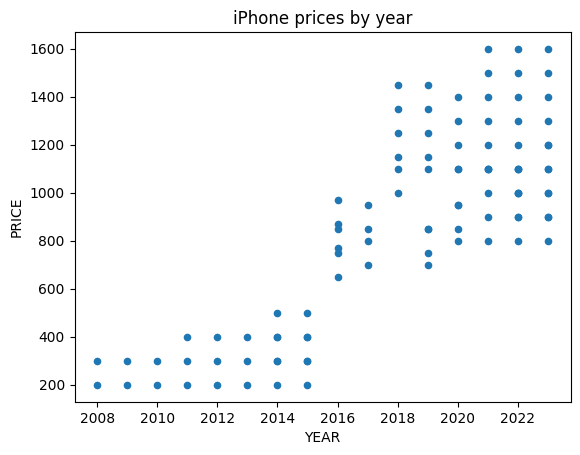

In [106]:
## DATA VISUALIZATION OF PRICES BY YEAR 
iphones.plot(kind="scatter", x="YEAR", y="PRICE", title="iPhone prices by year") 

# WE OBSERVE THAT PRICES HAVE A POSITIVE CORRELATION TO THE YEAR 

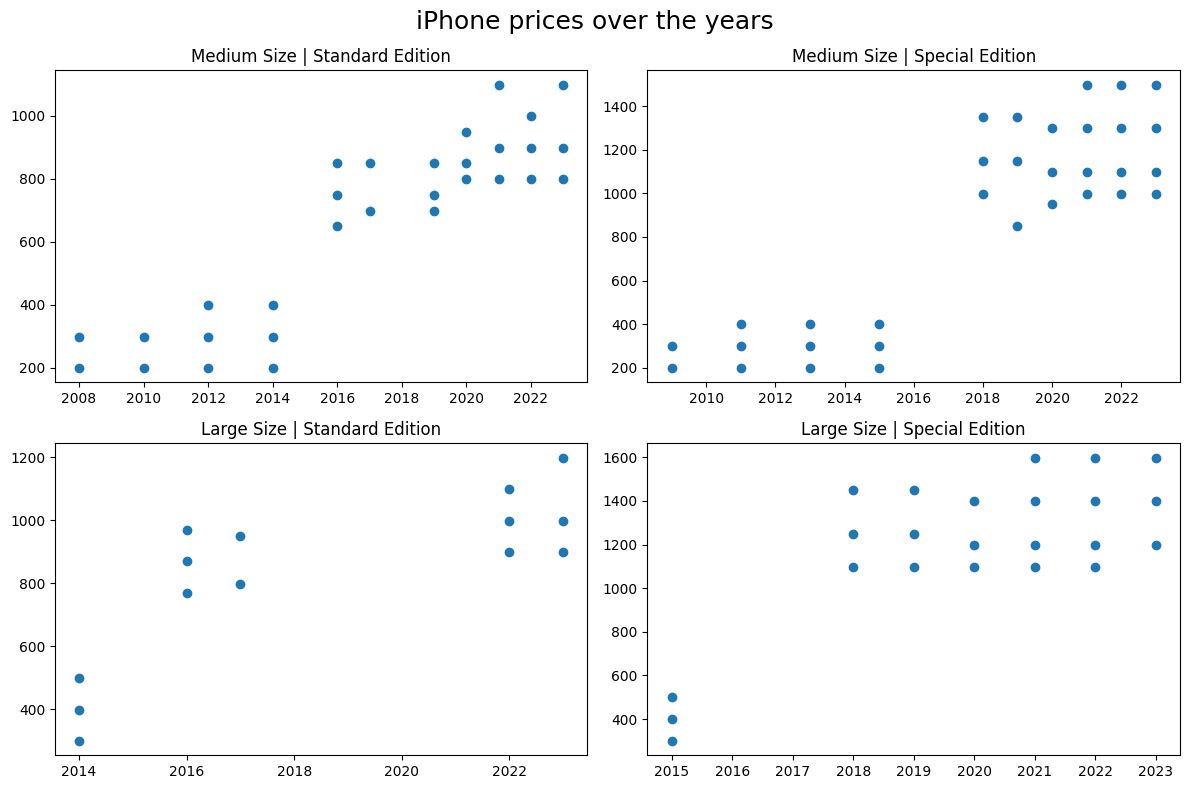

In [107]:
## DATA VISUALIZATION OF PRICES BY CATEGORY 

# PLOT AVERAGE PRICES OF IPHONE EDITIONS OVER THE YEARS 
# DIVIDE INTO CATEGORIES OF SIZE AND EDITION 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8)) 
fig.suptitle("iPhone prices over the years", size=18) 

# plot medium-sized, standard edition iPhones 
axes[0,0].set_title("Medium Size | Standard Edition") 
phones_med_std = iphones.loc[(0 == iphones["LARGE"]) & (0 == iphones["SPECIAL"])] 
axes[0,0].scatter(phones_med_std["YEAR"], phones_med_std["PRICE"])

# plot medium-sized, special edition iPhones 
axes[0,1].set_title("Medium Size | Special Edition") 
phones_med_spec = iphones.loc[(0 == iphones["LARGE"]) & (1 == iphones["SPECIAL"])] 
axes[0,1].scatter(phones_med_spec["YEAR"], phones_med_spec["PRICE"]) 

# plot large-sized, standard edition iPhones 
axes[1,0].set_title("Large Size | Standard Edition") 
phones_lg_std = iphones.loc[(1 == iphones["LARGE"]) & (0 == iphones["SPECIAL"])]
axes[1,0].scatter(phones_lg_std["YEAR"], phones_lg_std["PRICE"])

# plot large-sized, special edition iPhones 
axes[1,1].set_title("Large Size | Special Edition") 
phones_lg_spec = iphones.loc[(1 == iphones["LARGE"]) & (1 == iphones["SPECIAL"])] 
axes[1,1].scatter(phones_lg_spec["YEAR"], phones_lg_spec["PRICE"]) 

fig.tight_layout() 

# WE OBSERVE A SIGNIFICANT PRICE INCREASE IN ALL CATEGORIES BETWEEN 2016 AND 2018 

<Axes: title={'center': 'iPhone storage capacities by year'}, xlabel='YEAR', ylabel='GB'>

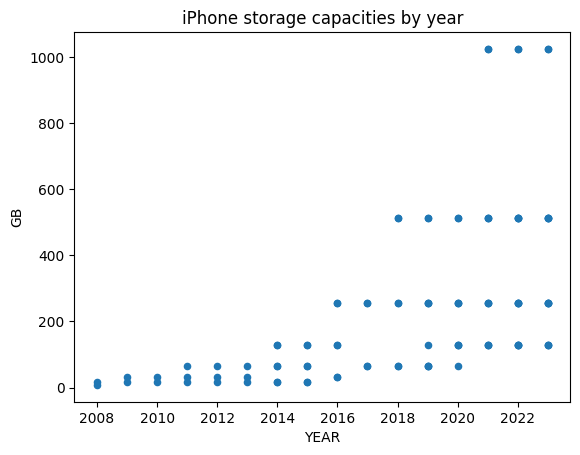

In [108]:
## DATA VISUALIZATION OF STORAGE CAPACITY BY YEAR 

iphones.plot("YEAR", "GB", kind="scatter", title="iPhone storage capacities by year") 

# WE OBSERVE: AS TIME ELAPSES, STORAGE CAPACITIES INCREASE 
# THERE SEEMS TO BE AN EXPONENTIAL (NON-LINEAR) RELATIONSHIP BETWEEN THESE TWO FEATURES 

<Axes: title={'center': 'iPhone prices by storage capacity'}, xlabel='GB', ylabel='PRICE'>

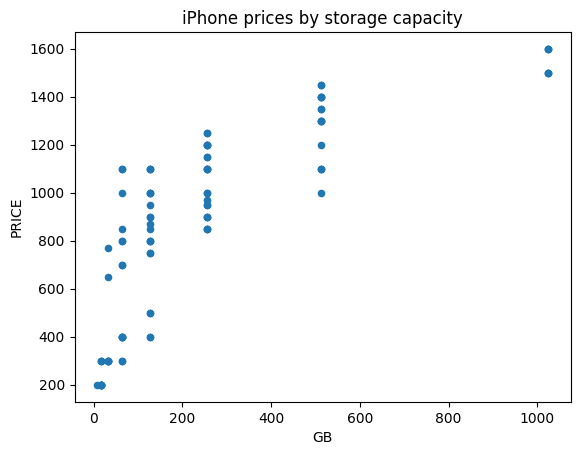

In [109]:
## DATA VISUALIZATION OF PRICES BY STORAGE CAPACITY 
iphones.plot(kind="scatter", x="GB", y="PRICE", title="iPhone prices by storage capacity") 

# WE OBSERVE A POSITIVE CORRELATION BETWEEN STORAGE CAPACITY AND PRICE 
# AS STORAGE CAPACITY INCREASES, SO DOES PRICE

<Axes: title={'center': 'iPhone prices by version'}, xlabel='VERSION', ylabel='PRICE'>

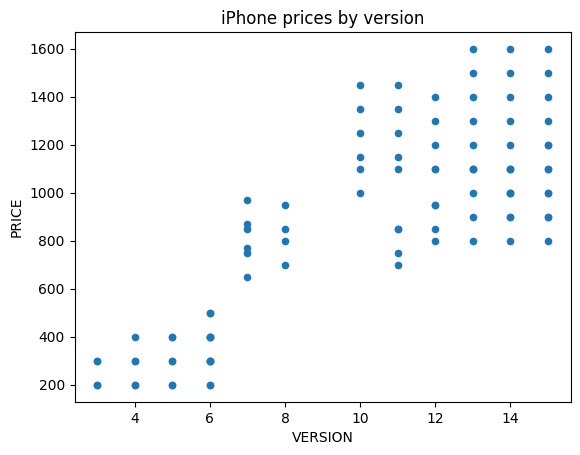

In [110]:
## DATA VISUALIZATION OF PRICES BY VERSION 
iphones.plot(kind="scatter", x="VERSION", y="PRICE", title="iPhone prices by version") 

# WE OBSERVE: AS VERSION NUMBER INCREASES, SO DOES PRICE 
# POSITIVE CORRELATION

<Axes: title={'center': 'iPhone prices per GB, by year'}, xlabel='YEAR', ylabel='PRICE_PER_GB'>

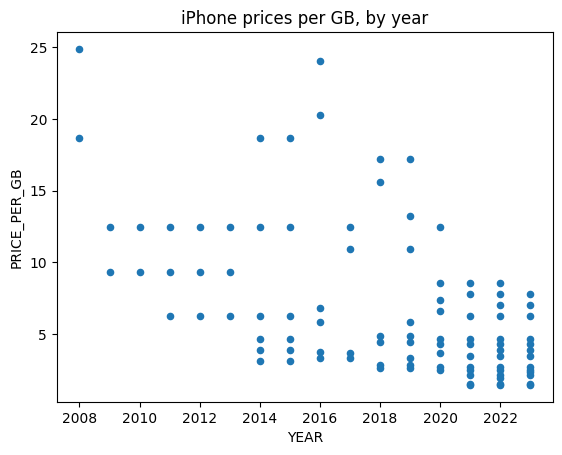

In [111]:
## DATA VISUALIZATION OF PRICE PER GB, BY YEARS 
iphones.plot(kind="scatter", x="YEAR", y="PRICE_PER_GB", title="iPhone prices per GB, by year") 

# WE OBSERVE A (NOISY) DECREASE PRICE_PER_GB OVER TIME 
# AS TIME ELAPSES, STORAGE CAPACITY BECOMES CHEAPER 

<Axes: title={'center': 'iPhone prices per GB, by total storage capacity'}, xlabel='GB', ylabel='PRICE_PER_GB'>

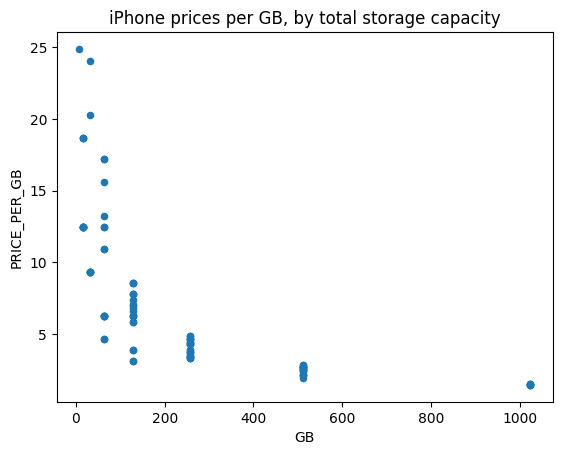

In [112]:
## DATA VISUALIZATION OF PRICE PER GB, BY STORAGE CAPACITY 
iphones.plot(kind="scatter", x="GB", y="PRICE_PER_GB", title="iPhone prices per GB, by total storage capacity") 

# WE OBSERVE A (NON-LINEAR) NEGATIVE CORRELATION BETWEEN PRICE PER GB AND STORAGE CAPACITY 
# AS STORAGE CAPACTY INCREASES, THE PRICE PER GIGABYTE BECOMES A "BETTER DEAL" 

In [113]:
## DROP PRICE_PER_GB COLUMN 
# this was mainly for illustration / analysis 
# since we already have "GB" and "PRICE", this extra column becomes redundant and introduces collinearity into the dataset 

iphones.drop("PRICE_PER_GB", axis=1, inplace=True) 

<Axes: title={'center': 'iPhone versions by year'}, xlabel='YEAR', ylabel='VERSION'>

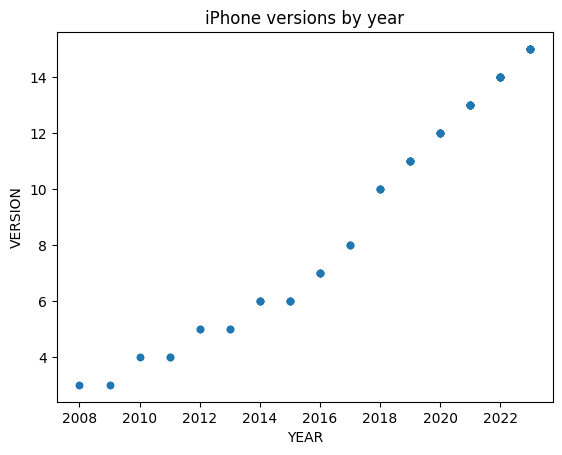

In [114]:
## DATA VISUALIZATION OF YEAR, BY VERSION 
iphones.plot(kind="scatter", x="YEAR", y="VERSION", title="iPhone versions by year") 

# WE OBSERVE HIGH COLLINEARITY BETWEEN "VERSION" AND "YEAR" (OBVIOUSLY) 
# THIS MEANS THAT WE SHOULD NOT USE THEM TOGETHER FOR MODELING / TRAINING 
# "VERSION" WILL BE OMITTED FROM TRAINING, SINCE "YEAR" WILL BE A USER INPUT AND "VERSION" CANNOT BE PREDICTED BY THE USER 

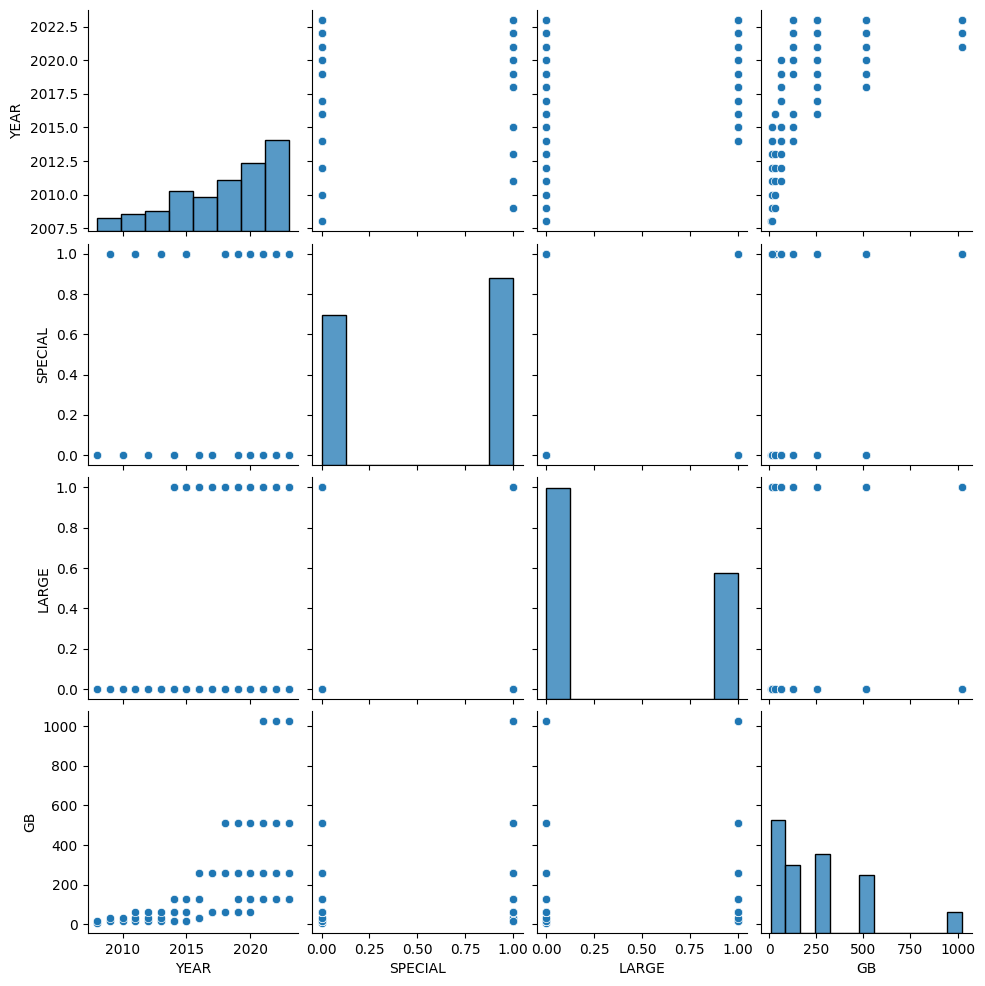

In [115]:
## DATA VISUALIZATION OF ALL FEATURES (EXCLUDING "VERSION" AND "PRICE") 
# WE ALREADY EXAMINED "PRICE" WITH OTHER FEATURES 

sns.pairplot(iphones.drop(["VERSION", "PRICE"], axis=1)) 

# WE OBSERVE A NOTABLE POSITIVE CORRELATION BETWEEN GB AND YEAR 
# however, this is not as much the year determining the storage, as much as technological availability 

In [116]:
# DROPPING "VERSION" FEATURE DUE TO HIGH COLLINEARITY WITH "YEAR"
# ALSO, THE USER SHOULDN'T HAVE TO INPUT THE VERSION NUMBER OF A FUTURE IPHONE, SINCE THEY DON'T KNOW IT 

iphones.drop("VERSION", axis=1, inplace=True)

### Step 3: Model Building 

In [117]:
numerical_features1 = ["YEAR", "GB"] 
binary_features1 = ["SPECIAL", "LARGE"] 

X1 = iphones[numerical_features1 + binary_features1] 
y1 = iphones["PRICE"] 

In [118]:
## SPLIT DATASET INTO TRAINING AND TESTING PARTS 

from sklearn.model_selection import train_test_split 

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, 
                                                    y1, 
                                                    test_size = 9/99, 
                                                    random_state = 1
                                                    ) 

In [119]:
## STANDARDIZE NUMERICAL FEATURES OF TRAINING DATA 

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 
scaler.fit(X1_train[numerical_features1]) 
X1_train[numerical_features1] = scaler.fit_transform(X1_train[numerical_features1]) 
X1_test[numerical_features1] = scaler.fit_transform(X1_test[numerical_features1])

Coefficients (weights)
YEAR       217.764682
GB         176.543419
SPECIAL    128.482767
LARGE       92.599876
dtype: float64


,TRUE,PRED,ERR_VAL,ERR_PERCENT
107,999.0,951.014553,-47.985447,-0.048033
98,1199.0,1054.732847,-144.267153,-0.120323
36,969.0,523.855362,-445.144638,-0.459386
95,1299.0,1118.501378,-180.498622,-0.138952
93,999.0,883.948767,-115.051233,-0.115166
21,399.0,218.939710,-180.060290,-0.451279
39,799.0,473.644843,-325.355157,-0.407203
96,1499.0,1431.238192,-67.761808,-0.045205
103,1099.0,1057.084397,-41.915603,-0.038140


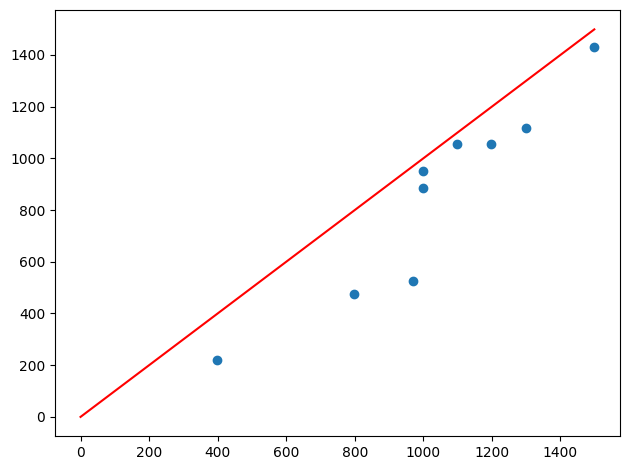

In [120]:
## LINEAR REGRESSION  

from sklearn.linear_model import LinearRegression 

ml_reg1 = LinearRegression() 
ml_reg1.fit(X1_train, y1_train) 
y1_pred = ml_reg1.predict(X1_test) 

# DISPLAY WEIGHTS OF EACH ATTRIBUTE IN CALCULATING TARGET VALUE(S) 
print("Coefficients (weights)") 
print(pd.Series(ml_reg1.coef_, index=X1_train.columns)) 

# CREATE DATAFRAME OF TRUE VALUES AND PREDICTED VALUES FOR COMPARISON 
ml_reg1_results = pd.DataFrame({ 
    "TRUE": y1_test, 
    "PRED": y1_pred, 
    "ERR_VAL": (y1_pred - y1_test) 
}) 

# ADD COLUMN OF PERCENTAGE OF ERROR FROM THE TRUE VALUE 
ml_reg1_results["ERR_PERCENT"] = ml_reg1_results["ERR_VAL"] / ml_reg1_results["TRUE"] 

fig, ax = plt.subplots() 
ax.scatter(x = ml_reg1_results["TRUE"], y = ml_reg1_results["PRED"]) 
ax.plot([0, ml_reg1_results["TRUE"].max()], [0,ml_reg1_results["TRUE"].max()], color="red")
fig.tight_layout()

# DISPLAY DATAFRAME OF RESULT COMPARISON 
ml_reg1_results 

# WE OBSERVE THAT THIS LINEAR REGRESSION MODEL IS UNDERESTIMATING THE PRICES, SOMETIMES BY A SIGNIFICANT AMOUNT 
# WE ALSO OBSERVE THAT HIGHER PRICES TEND TO HAVE MORE ACCURATE PREDICTIONS, ESPECIALLY IN RANDOM-STATE 1 
# THERE IS ROOM FOR IMPROVEMENT 

### Step 4: Model Evaluation 

In [121]:
## DUMMY REGRESSOR 

from sklearn.dummy import DummyRegressor 

dummy_reg = DummyRegressor(strategy="mean") 
dummy_reg.fit(X1_train, y1_train) 
dummy_pred = dummy_reg.predict(X1_test) 

In [122]:
## CALCULATE MEAN SQUARED ERROR (MSE) 

from sklearn.metrics import mean_squared_error 

ml_reg1_mse = mean_squared_error(y_true=y1_test, y_pred=y1_pred) 
dummy_mse = mean_squared_error(y_true=y1_test, y_pred=dummy_pred) 

pd.DataFrame({
    "MSE": [ml_reg1_mse, dummy_mse, dummy_mse - ml_reg1_mse],
}, index=["Regression", "Dummies", "Improvement"])

# WE OBSERVE: LINEAR REGRESSION REDUCES THE MEAN SQUARED ERROR FROM A NULL MODEL TO LESS THAN HALF 
# THIS IS GOOD, BUT IMPROVEMENTS CAN STILL BE MADE 

,MSE
Regression,45745.796494
Dummies,115164.456790
Improvement,69418.660296


#### Proposed modification: Change "GB" feature to dummies, to see if it increases the performance of this Linear Regression modelv

In [123]:
## GET DUMMIES FOR STORAGE VALUES 
# base case: 8GB 

storage_dummies = pd.get_dummies(iphones["GB"], prefix="GB", drop_first=True) 

iphones2 = iphones.copy()

iphones2 = pd.concat( 
    [
        iphones2, 
        storage_dummies.astype(int) 
    ], 
    axis = 1 
) 

# drop "GB" column 
iphones2.drop("GB", axis=1, inplace=True) 

# REMOVE "GB" FROM NUMERICAL FEATURES 
numerical_features2 = ["YEAR"] 

# ADD STORAGE DUMMIES TO BINARY FEATURES 
binary_features2 = binary_features1 + [gb_size for gb_size in storage_dummies.columns]

In [124]:
# RE-APPLY TRANSFORMATIONS TO NEWLY ADJUSTED DATASET 

# SPLIT NEW DATASET FOR TRAINING AND TESTING 

X2 = iphones2[numerical_features2 + binary_features2]
y2 = iphones2["PRICE"] 

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, 
                                                    test_size = 9/99, 
                                                    random_state = 1 
                                                    ) 

# STANDARDIZE DATASET'S NUMERICAL FEATURES (ONLY YEAR, IN THIS CASE) 
X2_train[numerical_features2] = scaler.fit_transform(X2_train[numerical_features2]) 
X2_test[numerical_features2] = scaler.fit_transform(X2_test[numerical_features2]) 

In [125]:
# RE-TRAIN MODEL WITH UPDATED DATASET FORMAT 

ml_reg2 = LinearRegression()
ml_reg2.fit(X2_train, y2_train) 
y2_pred = ml_reg2.predict(X2_test) 

# print coefficient comparison between old and new models 
pd.DataFrame({ 
    "OLD WEIGHTS": pd.Series(ml_reg1.coef_, index=X1_train.columns), 
    "NEW WEIGHTS": pd.Series(ml_reg2.coef_, index=X2_train.columns), 
}).sort_values(by="OLD WEIGHTS", ascending=False) 

# WE OBSERVE:
# "YEAR" has a reduced in weight, but is still the leading coefficient 
# "SPECIAL" has remained about the same 
# "LARGE" has also remained about the same 
# THE WEIGHT OF THE "GB" COLUMN IN THE OLD MODEL IS EXCEEDED BY THE WEIGHTS OF THE DUMMIES IN THE NEW MODEL 
# THE NEW MODEL HAS OVERALL MORE WEIGHING AND MORE FACTORS THAT CONTRIBUTE TOWARD CALCULATING THE TARGET VALUE(S) 

,OLD WEIGHTS,NEW WEIGHTS
YEAR,217.764682,151.901905
GB,176.543419,NaN
SPECIAL,128.482767,130.687083
LARGE,92.599876,95.748874
GB_1024,NaN,660.379036
GB_128,NaN,111.852050
GB_16,NaN,-204.285222
GB_256,NaN,294.932887
GB_32,NaN,-14.340439
GB_512,NaN,485.453716


In [126]:
# CALCULATE MSE FOR MODEL 2 

ml_reg2_mse = mean_squared_error(y_true=y2_test, y_pred=y2_pred) 

pd.DataFrame({
    "NULL": [dummy_mse, None], 
    "OLD": [ml_reg1_mse, dummy_mse - ml_reg1_mse], 
    "NEW": [ml_reg2_mse, dummy_mse - ml_reg2_mse]
}, index=["MSE", "IMPROVEMENT"]) 

# WE OBSERVE THAT MODEL 2 SIGNIFICANTLY OUTPERFORMS MODEL 1 
# WHILE BOTH MODELS PERFORM WELL, MODEL 2 REDUCED THE MSE BY 100K FROM THE NULL MODEL 
# SO FAR, FROM THIS PERSPECTIVE, IS SEEMS LIKE MODEL 2 IS THE BETTER OPTION 

,NULL,OLD,NEW
MSE,115164.45679,45745.796494,14617.055766
IMPROVEMENT,NaN,69418.660296,100547.401024


,TRUE,PRED,ERR_VAL,ERR_PERCENT
103,1099.0,1183.323449,84.323449,0.076727
98,1199.0,1172.456790,-26.543210,-0.022138
95,1299.0,1267.228746,-31.771254,-0.024458
21,399.0,388.685712,-10.314288,-0.025850
96,1499.0,1442.154065,-56.845935,-0.037923
107,999.0,940.408866,-58.591134,-0.058650
93,999.0,893.627080,-105.372920,-0.105478
36,969.0,761.078994,-207.921006,-0.214573
39,799.0,550.758706,-248.241294,-0.310690


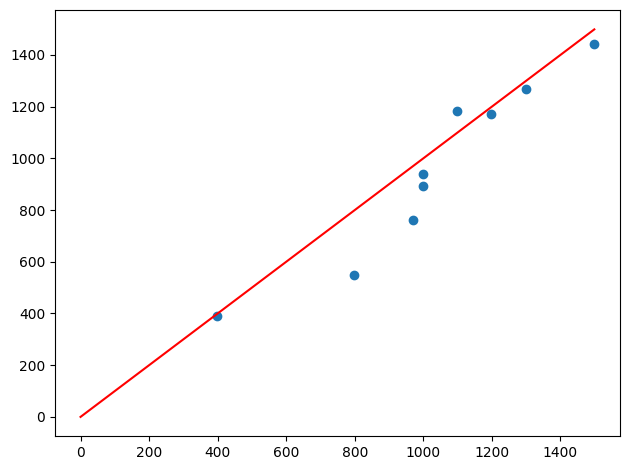

In [127]:
# DISPLAY ERRORS AND PERCENTAGE OF MODEL 2 

ml_reg2_results = pd.DataFrame({ 
    "TRUE": y2_test, 
    "PRED": y2_pred, 
    "ERR_VAL": (y2_pred - y2_test) 
}) 

# ADD COLUMN OF PERCENTAGE OF ERROR FROM THE TRUE VALUE 
ml_reg2_results["ERR_PERCENT"] = ml_reg2_results["ERR_VAL"] / ml_reg2_results["TRUE"] 

fig, ax = plt.subplots() 
ax.scatter(x=ml_reg2_results["TRUE"], y=ml_reg2_results["PRED"]) 
ax.plot([0, ml_reg2_results["TRUE"].max()], [0, ml_reg2_results["TRUE"].max()], color="red")
fig.tight_layout() 

ml_reg2_results.sort_values(by="ERR_PERCENT", ascending=False)

#### Proposed modification: Transform the "dummies" of storage capacities to be ordinal such that each sample has a successive series of 1's leading up to its true capacity 
##### example: if an iPhone has 64GB, its values for "GB_16", "GB_32", and "GB_64", will all be 1; instead of only the "GB_64" being 1 
##### This may (or may not) result in better predictive performance 

In [218]:
## MODEL 3: PRE-PROCESSING 

# create copy of iphones2 dataFrame, to build onto 
iphones3 = iphones2.copy() 

# get list of storage capacity values, excluding 8 (GB) 
storage_values = iphones["GB"].value_counts().index.sort_values(ascending=True)[1:] 

# reverse list of storage capacities 
storage_values = list(reversed(storage_values)) 

for i in range(len(storage_values[:-1])): 
    gb = storage_values[i] 
    iphones3

1024
512
256
128
64
32


In [168]:
saveOutput(iphones, "iphones_output.csv") 
saveOutput(iphones2, "iphones2_output.csv")

iphones2

,YEAR,SPECIAL,LARGE,PRICE,GB_16,GB_32,GB_64,GB_128,GB_256,GB_512,GB_1024
2,2008,0,0,199.0,0,0,0,0,0,0,0
3,2008,0,0,299.0,1,0,0,0,0,0,0
4,2009,1,0,199.0,1,0,0,0,0,0,0
5,2009,1,0,299.0,0,1,0,0,0,0,0
6,2010,0,0,199.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
109,2023,1,0,1299.0,0,0,0,0,0,1,0
110,2023,1,0,1499.0,0,0,0,0,0,0,1
111,2023,1,1,1199.0,0,0,0,0,1,0,0
112,2023,1,1,1399.0,0,0,0,0,0,1,0
